# Defining the Problem

Computing the optimal policy/policies is a well constructed Reinforcement learning problem given the reward structure. The reward plays a pivotal factor in deciding the course of the policy. 

The objective of the Inverse Reinforcement Learning is to learn the reward structure given the optimal policy. This line of thinking has now given rise to different types of IRL problems called apprenticeship learning or imitation learning. This could be used by an expert agent  to train a new agent to perform the same kind of task. All the beginner agent would have to do is to imitate the policy followed by the expert and hence identify the reward structure 

The Inverse Reinforcement Learning problem was proposed in 200o by Ng and Russel

## The Implementation

The dependencies needed are imported as shown. The implementation is run on a gridworld. We make use of a standard gridworld environement publicly available for use in our implementation.

In [13]:
import numpy as np
from gridworld import GridWorld
import matplotlib.pyplot as plt
import pdb
%matplotlib notebook

The below function is used to print the action sampled according to the policy of the agent. It helps for better visualization while running the code

In [14]:
def print_policy(policy_matrix):
    '''Print the policy using specific symbol.

    * terminal state
    ^ > v < up, right, down, left
    # obstacle
    '''
    counter = 0
    shape = policy_matrix.shape
    policy_string = ""
    for row in range(shape[0]):
        for col in range(shape[1]):
            if(policy_matrix[row,col] == -1): policy_string += " *  "
            elif(policy_matrix[row,col] == 0): policy_string += " ^  "
            elif(policy_matrix[row,col] == 1): policy_string += " >  "
            elif(policy_matrix[row,col] == 2): policy_string += " v  "
            elif(policy_matrix[row,col] == 3): policy_string += " <  "
            elif(np.isnan(policy_matrix[row,col])): policy_string += " #  "
            counter += 1
        policy_string += '\n'
    print(policy_string)

The function below calculates of the return, <b>Q(s,a)</b>, for a state-action pair

In [15]:
def get_return(state_list, gamma):
    '''Get the return for a list of action-state values.

    @return get the Return
    '''
    #pdb.set_trace()
    counter = 0
    return_value = 0
    for visit in state_list:
        reward = visit[2]
        return_value += reward * np.power(gamma, counter)
        counter += 1
    return return_value

We define an update policy function to choose the greediest policy by looking at the state action matrix

In [16]:
def update_policy(episode_list, policy_matrix, state_action_matrix):
    '''Update a policy making it greedy in respect of the state-action matrix.

    @return the updated policy
    '''
    for visit in episode_list:
        #pdb.set_trace()
        observation = visit[0]
        col = observation[1] + (observation[0]*4)
        if(policy_matrix[observation[0], observation[1]] != -1):
            policy_matrix[observation[0], observation[1]] = \
                np.argmax(state_action_matrix[:,col])
    return policy_matrix

The below optimization problem has to be solved for the finite state space problem described in Ng & Russell, 2000.

![IRL_LP_eq](Images/IRL_LP_eq.png)

The below function makes use fo the cvxopt library in python to solve the linear programming problem. The Rmax value is chosen to be 10 based on some prior hunchof our rewards

In [17]:
from cvxopt import matrix, solvers

def irl(n_states, n_actions, transition_probability, policy, discount, Rmax,
        l1):
    """
    Find a reward function with inverse RL as described in Ng & Russell, 2000.

    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probability: NumPy array mapping (state_i, action, state_k) to
        the probability of transitioning from state_i to state_k under action.
        Shape (N, A, N).
    policy: Vector mapping state ints to action ints. Shape (N,).
    discount: Discount factor. float.
    Rmax: Maximum reward. float.
    l1: l1 regularisation. float.
    """

    A = set(range(n_actions))  # Set of actions to help manage reordering
                               # actions.
    # The transition policy convention is different here to the rest of the code
    # for legacy reasons; here, we reorder axes to fix this. We expect the
    # new probabilities to be of the shape (A, N, N).
    transition_probability = np.transpose(transition_probability, (1, 0, 2))

    def T(a, s):
        """
        Shorthand for a dot product used a lot in the LP formulation.
        """

        return np.dot(transition_probability[policy[s], s] -
                      transition_probability[a, s],
                      np.linalg.inv(np.eye(n_states) -
                        discount*transition_probability[policy[s]]))

    # This entire function just computes the block matrices used for the LP
    # formulation of IRL.

    # Minimise c . x.
    c = -np.hstack([np.zeros(n_states), np.ones(n_states),
                    -l1*np.ones(n_states)])
    zero_stack1 = np.zeros((n_states*(n_actions-1), n_states))
    T_stack = np.vstack([
        -T(a, s)
        for s in range(n_states)
        for a in A - {policy[s]}
    ])
    I_stack1 = np.vstack([
        np.eye(1, n_states, s)
        for s in range(n_states)
        for a in A - {policy[s]}
    ])
    I_stack2 = np.eye(n_states)
    zero_stack2 = np.zeros((n_states, n_states))

    D_left = np.vstack([T_stack, T_stack, -I_stack2, I_stack2])
    D_middle = np.vstack([I_stack1, zero_stack1, zero_stack2, zero_stack2])
    D_right = np.vstack([zero_stack1, zero_stack1, -I_stack2, -I_stack2])

    D = np.hstack([D_left, D_middle, D_right])
    b = np.zeros((n_states*(n_actions-1)*2 + 2*n_states, 1))
    bounds = np.array([(None, None)]*2*n_states + [(-Rmax, Rmax)]*n_states)

    # We still need to bound R. To do this, we just add
    # -I R <= Rmax 1
    # I R <= Rmax 1
    # So to D we need to add -I and I, and to b we need to add Rmax 1 and Rmax 1
    D_bounds = np.hstack([
        np.vstack([
            -np.eye(n_states),
            np.eye(n_states)]),
        np.vstack([
            np.zeros((n_states, n_states)),
            np.zeros((n_states, n_states))]),
        np.vstack([
            np.zeros((n_states, n_states)),
            np.zeros((n_states, n_states))])])
    b_bounds = np.vstack([Rmax*np.ones((n_states, 1))]*2)
    D = np.vstack((D, D_bounds))
    b = np.vstack((b, b_bounds))
    A_ub = matrix(D)
    b = matrix(b)
    c = matrix(c)
    solvers.options['show_progress'] = False
    results = solvers.lp(c, A_ub, b)
    r = np.asarray(results["x"][:n_states], dtype=np.double)

    return r.reshape((n_states,))

# The IRL problem for a finite state Space

We choose a 5x5 Grid world for our agent to run in. We set the terminal state of the grid world in the top left corner. The actions of the agent would be top, down , left, right. Rewards of the every state except the terminal state are considered to be zero. The terminal state is assigned a reward of 1.

In [18]:
env = GridWorld(5, 5)

#Define the state matrix
state_matrix = np.zeros((5,5))
state_matrix[0, 4] = 1     # terminal state
print("State Matrix:")
print(state_matrix)

#Define the reward matrix
reward_matrix = np.full((5,5), 0)
reward_matrix[0, 4] = 1    # terminal state
print("Reward Matrix:")
print(reward_matrix)

State Matrix:
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Reward Matrix:
[[0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


Our policy is stochastic with a probability of 0.1 each of moving in the direction not intended by the policy, i.e 30% chance of error

In [19]:
#Define the transition matrix
wind_effect_matrix = np.array([[0.7, 0.1, 0.1, 0.1],
                              [0.1, 0.7, 0.1, 0.1],
                              [0.1, 0.1, 0.7, 0.1],
                              [0.1, 0.1, 0.1, 0.7]])

#Random policy
policy_matrix = np.random.randint(low=0, high=4, size=(5, 5)).astype(np.float32)
policy_matrix[0,4] = -1

#Set the matrices in the world
env.setStateMatrix(state_matrix)
env.setRewardMatrix(reward_matrix)
env.setTransitionMatrix(wind_effect_matrix)

state_action_matrix = np.random.random_sample((4,25)) # Q

#init with 1.0e-10 to avoid division by zero
running_mean_matrix = np.full((4,25), 1.0e-10)
gamma = 0.5
tot_epoch = 30000
print_epoch = 3000

We now compute the optimal policy by running value iteration on our agent for its transition dynamics

In [20]:
for epoch in range(tot_epoch):
    #Starting a new episode
    episode_list = list()
    #Reset and return the first observation and reward
    observation = env.reset(exploring_starts=False)
    #action = np.random.choice(4, 1)
    #action = policy_matrix[observation[0], observation[1]]
    #episode_list.append((observation, action, reward))
    is_starting = True
    for _ in range(1000):
        #Take the action from the action matrix
        action = policy_matrix[observation[0], observation[1]]
        #If the episode just started then it is
            #necessary to choose a random action (exploring starts)
        if(is_starting):
            action = np.random.randint(0, 4)
            is_starting = False
        #Move one step in the environment and get obs and reward
        new_observation, reward, done = env.step(action)
        #Append the visit in the episode list
        episode_list.append((observation, action, reward))
        observation = new_observation
        if done: break
    #The episode is finished, now estimating the utilities

    #pdb.set_trace()
    counter = 0
    #Checkup to identify if it is the first visit to a state
    checkup_matrix = np.zeros((4,25))
    #This cycle is the implementation of First-Visit MC.
    #For each state stored in the episode list check if it
    #is the rist visit and then estimate the return.
    for visit in episode_list:
        observation = visit[0]
        action = visit[1]
        col = int(observation[1] + (observation[0]*4))
        row = int(action)
        if(checkup_matrix[row, col] == 0):
            return_value = get_return(episode_list[counter:], gamma)
            running_mean_matrix[row, col] += 1
            state_action_matrix[row, col] += return_value
            checkup_matrix[row, col] = 1
        counter += 1
    #Policy Update
    policy_matrix = update_policy(episode_list,
                                  policy_matrix,
                                  state_action_matrix/running_mean_matrix)
    #Printing
    if(epoch % print_epoch == 0):
        print("")
        print("State-Action matrix after " + str(epoch+1) + " iterations:")
        print(state_action_matrix / running_mean_matrix)
        print("Policy matrix after " + str(epoch+1) + " iterations:")
        print(policy_matrix)
        print_policy(policy_matrix)
#Time to check the utility matrix obtained
print("***********************************")
print("**************RESULTS**************")
print("Utility matrix after " + str(tot_epoch) + " iterations:")
print("\n\tQpi\n")
print(state_action_matrix / running_mean_matrix)

print("\n\tpi\n")
print(policy_matrix)
print(print_policy(policy_matrix))

state_value_matrix = state_action_matrix.max(axis=0)
print("\n\tVpi\n")
print(state_value_matrix)
print("***********************************")

policy_matrix[policy_matrix==-1] = 0
final_policy_list = policy_matrix.reshape(-1).astype(int)


State-Action matrix after 1 iterations:
[[4.72977569e+09 8.43795604e+09 8.50221405e+09 3.41000524e+08
  5.03055189e+09 9.57274802e+09 9.17091333e+09 5.34926978e+09
  1.68092494e+00 3.98797938e+08 3.90107664e+09 7.65137741e+09
  4.71489007e+08 9.56355879e+08 8.16686494e+09 7.18192708e+09
  6.91581067e-02 5.52000810e+09 1.95171340e+08 2.30750898e+09
  9.46855510e+09 7.92377782e+09 3.93148983e+09 6.25328302e+09
  7.73668175e+09]
 [9.14296492e+09 6.89024112e+09 2.31209502e+09 3.60230587e+09
  3.07736600e+09 2.42921909e+09 4.48951110e+09 3.54144735e+09
  4.42796150e+09 2.21683024e+09 1.11135772e+09 6.80633618e+09
  5.23037887e-01 6.02778687e+09 1.95796161e+09 6.34870309e+09
  2.68984867e-01 5.45516450e+08 6.52556397e-01 5.13185706e-01
  4.10573285e-01 5.69166340e+09 8.15859181e+09 6.67577028e+09
  2.74407748e+09]
 [5.97379318e+09 9.53924918e+09 5.61293322e+09 2.04000341e+09
  9.08667659e+09 8.06709115e+09 7.41152076e+09 2.65635994e+09
  8.24980233e+07 1.85441868e+09 8.09252517e+09 6.772844


State-Action matrix after 15001 iterations:
[[3.89023532e-02 7.42264013e-02 2.07544281e-01 3.80063024e-02
  1.98182327e-02 4.80064345e-02 1.23189774e-01 3.17057958e-01
  5.78566253e-02 1.77777642e-02 5.22756457e-02 1.32108735e-01
  1.34265121e-02 8.40694867e-03 2.23598589e-02 5.23944324e-02
  3.40704435e-03 3.99221733e-03 8.59920783e-03 2.14966272e-02
  3.94139235e-02 7.92377782e+09 3.93148983e+09 6.25328302e+09
  7.73668175e+09]
 [4.29778596e-02 1.12794399e-01 2.93619264e-01 7.64713942e-01
  2.05401900e-02 4.57830959e-02 1.03950231e-01 2.39633403e-01
  5.47064057e-02 2.12765062e-02 4.47826679e-02 1.16045657e-01
  1.22354161e-02 9.29324413e-03 2.10765201e-02 4.05850142e-02
  1.70516076e-03 3.75968492e-03 9.52152407e-03 1.74523173e-02
  2.84417179e-02 5.69166340e+09 8.15859181e+09 6.67577028e+09
  2.74407748e+09]
 [3.76490321e-02 7.45095622e-02 1.88399857e-01 3.29000341e-01
  1.95189467e-02 4.51064708e-02 1.01068345e-01 1.32818027e-01
  8.24980233e-03 1.72360446e-02 4.73643941e-02 1.15

***********************************
**************RESULTS**************
Utility matrix after 30000 iterations:

	Qpi

[[3.89023532e-02 7.42264013e-02 2.07544281e-01 3.80063024e-02
  1.98182327e-02 4.82841418e-02 1.23328940e-01 3.17942409e-01
  5.65594177e-02 1.77777642e-02 5.26491770e-02 1.33738439e-01
  1.35417316e-02 8.40694867e-03 2.24562150e-02 5.42057322e-02
  3.70300268e-03 4.06091919e-03 8.59920783e-03 2.28542251e-02
  4.37992833e-02 7.92377782e+09 3.93148983e+09 6.25328302e+09
  7.73668175e+09]
 [4.37891399e-02 1.13610050e-01 2.94814835e-01 7.66160124e-01
  2.05245900e-02 4.57830959e-02 1.03950231e-01 2.39633403e-01
  5.47064057e-02 2.16529967e-02 4.47826679e-02 1.16045657e-01
  1.22354161e-02 9.39025079e-03 2.10765201e-02 4.05850142e-02
  1.75713069e-03 3.75968492e-03 9.86171062e-03 1.74523173e-02
  2.84417179e-02 5.69166340e+09 8.15859181e+09 6.67577028e+09
  2.74407748e+09]
 [3.76490321e-02 7.45095622e-02 1.88399857e-01 3.29000341e-01
  1.95189467e-02 4.51064708e-02 1.010683

In [21]:
print("LP Calculation starts ...")

# ## Random State Transition Matrix


random_state_transition_matrix = np.random.rand(25,4,25)
random_state_transition_matrix = random_state_transition_matrix/random_state_transition_matrix.sum(axis=1)[:,None]
#print(random_state_transition_matrix.shape)


# ## With a handcrafted State Transition Matrix

fixed_state_transition_matrix = np.load("gw_transition_probability.npy")
#print(fixed_state_transition_matrix.shape)

# ## Random policy
random_policy = np.random.randint(4,size=(5,5)).reshape(-1).astype(int)

LP Calculation starts ...


## Recoverd Rewards

We now test our functions in 3 cases
<ol>
<li> The transition dynamics are random</li>
<li> The policy is random</li>
<li> The transition dynamics are handcrafted</li>
</ol>

<b>1) </b>In the first case. The transition dynamics of the agent are random. Running our lp solver in this case would not be able to learn the optimal reward structure and would give us erroneous results.

<IPython.core.display.Javascript object>


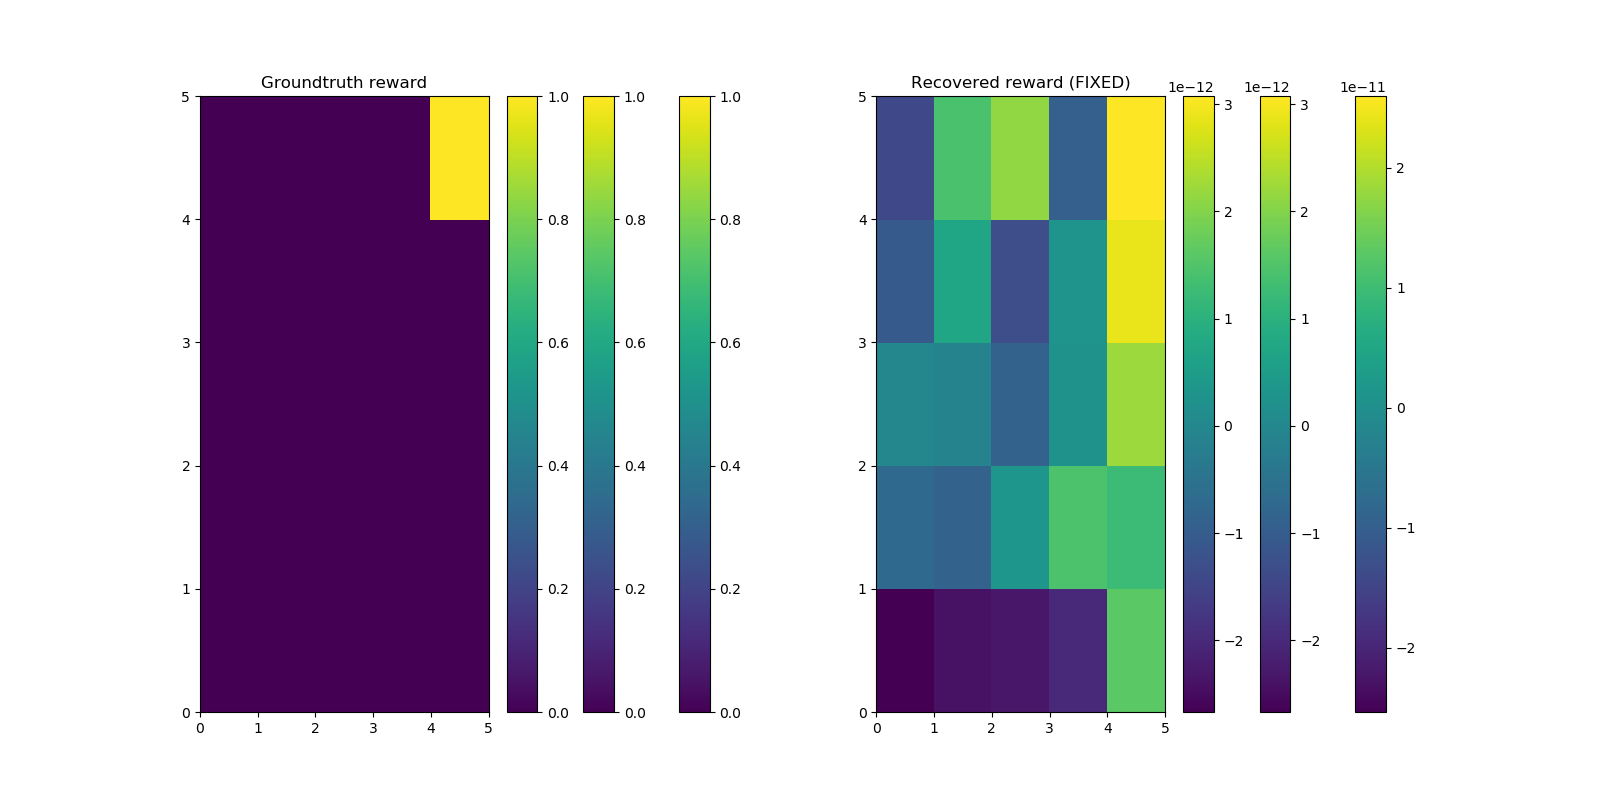

Text(0.5,1,'Recovered reward (RANDOM TRANSITION)')

In [25]:
r_random = irl(n_states=25,n_actions=4,transition_probability=random_state_transition_matrix, policy=final_policy_list,discount=0.2,Rmax=1,l1=5)
fig = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.pcolor(np.flip(reward_matrix,0))
plt.colorbar()
plt.title("Groundtruth reward")
plt.subplot(1,2,2)
plt.pcolor(r_random.reshape((5, 5)))
plt.colorbar()
plt.title("Recovered reward (RANDOM TRANSITION)")
#plt.show()

<b>2) </b>In the second case, we see how our agent would learn from a random policy. It is understandable that a non optimal policy shouldn't give us the same reward structure. If it did that would mean all non optimal policies are capable of recovering the same reward structure which would be a contradiction

<IPython.core.display.Javascript object>


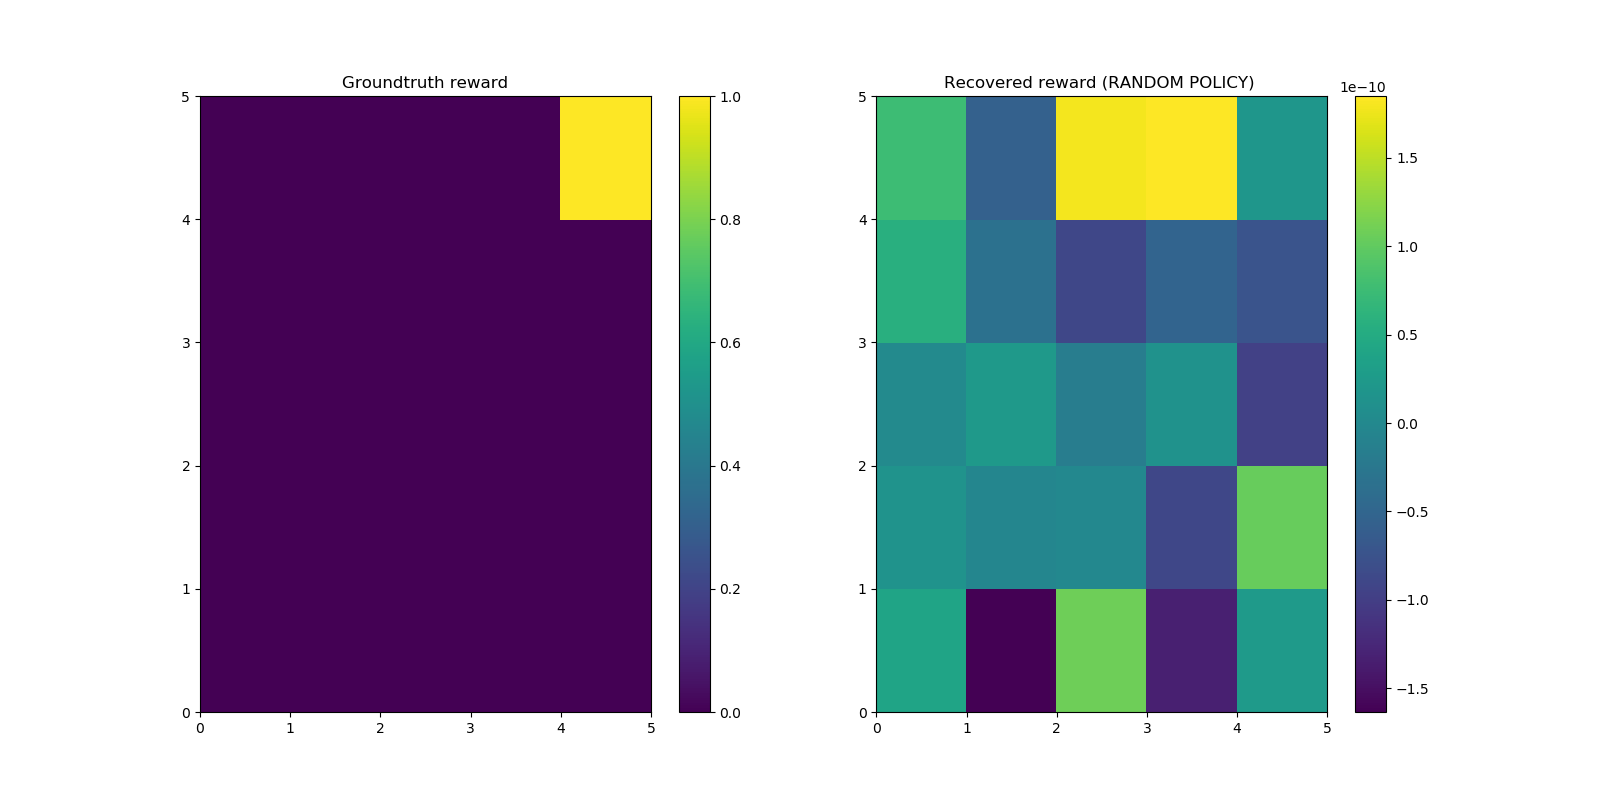

Text(0.5,1,'Recovered reward (RANDOM POLICY) ')

In [23]:
r_random_policy = irl(n_states=25,n_actions=4,transition_probability=fixed_state_transition_matrix,    policy=random_policy,discount=0.5,Rmax=10,l1=5)

plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)

plt.pcolor(np.flip(reward_matrix,0))
plt.colorbar()
plt.title("Groundtruth reward")
plt.subplot(1,2,2)
plt.pcolor(r_random_policy.reshape((5,5)))
plt.colorbar()
plt.title("Recovered reward (RANDOM POLICY) ")
#plt.show()

<b>3)</b> In this case we use handcrafted transition probabilities for the agent and try to find the inverse of the optimal policy. This is the problem defined by Ng and Russell. It can be seen that we are able to recover our reward structure to some degree. Imposing/Modifying the constraints by adjusting the value of lambda would also help us control the sparsity of our reward structure

In [27]:
r_fixed = irl(n_states=25,n_actions=4,transition_probability=fixed_state_transition_matrix,  policy=final_policy_list,discount=0.5,Rmax=10,l1=5)
#plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.pcolor(np.flip(reward_matrix,0))
plt.colorbar()
plt.title("Groundtruth reward")
plt.subplot(1,2,2)
plt.pcolor(r_fixed.reshape((5, 5)))
plt.colorbar()
plt.title("Recovered reward (FIXED)")
plt.show()

print("Optimal Reward found!")

Optimal Reward found!
